In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10 -cellw 80%
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

In [4]:
mpl.rcParams['image.cmap'] = 'gray' # mpl is matplotlib apparently...

In [5]:
x_train,y_train,x_valid,y_valid = get_data()

In [11]:
x_train.shape

torch.Size([50000, 784])

In [64]:
n,m = x_train.shape # m is the flattened image dimension, so 28x28 = 784
c = y_train.max()+1
nh = 50

In [7]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.layers = [nn.Linear(n_input,n_hidden), nn.ReLU(), nn.Linear(n_hidden,n_output)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [8]:
model = Model(m, nh, 10) # flattened model with 784 inputs and 10 outputs (the digits) 

In [10]:
pred = model(x_train); pred

tensor([[-0.0471, -0.0967, -0.1099,  ...,  0.0900,  0.0047,  0.2372],
        [ 0.0247, -0.2072, -0.1365,  ..., -0.0129,  0.1346,  0.2050],
        [ 0.0291, -0.1477, -0.1248,  ..., -0.0913,  0.1627,  0.2181],
        ...,
        [ 0.0478, -0.0844, -0.0107,  ...,  0.0496,  0.1306,  0.2339],
        [-0.0378, -0.0786, -0.0345,  ...,  0.0670,  0.1827,  0.1993],
        [-0.0400, -0.1040, -0.0159,  ...,  0.0344,  0.1617,  0.2309]],
       grad_fn=<AddmmBackward>)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.


We'll use PyTorch autograd now, so we won't need to see the gradient of these things. You can see how to compute them though all around the web; for example [here](https://gitlab.com/mbant/cs224n/blob/master/a2/a2_solutions.pdf)

In [12]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [13]:
sm_pred = log_softmax(pred)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [14]:
y_train[:3]

tensor([5, 0, 4])

In [22]:
sm_pred[[0,1,2], [5,0,4]] # this is  tensor([sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]]) 

tensor([-2.1670, -2.2648, -2.5428], grad_fn=<IndexBackward>)

In [23]:
tensor([sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]]) 

tensor([-2.1670, -2.2648, -2.5428])

In [24]:
y_train.shape[0]

50000

In [25]:
def nll(input, target): return -input[range(target.shape[0]), target].mean() 
# also called cross-entropy

In [26]:
loss = nll(sm_pred, y_train)

In [27]:
loss

tensor(2.3099, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [28]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log() # better, but we can improve

In [30]:
test_near(nll(log_softmax(pred), y_train), loss) # check it works

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [42]:
def logsumexp(x):
    m = x.max(-1)[0] # this computes the max for each sample in the batch
    return m + (x-m[:,None]).exp().sum(-1).log() 
# [:,None] is needed to broadcast on the 1st axis

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [44]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [46]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [47]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [48]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [49]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [53]:
loss_func = F.cross_entropy

In [54]:
#export
def accuracy(output, target): 
    """
    Define accuracy as a metric to visualize instead of the loss itself
    Returns the average number of hits while comparing our `output` from a classifier
    and the `target`.
    """
    return (torch.argmax(output, dim=1)==target).float().mean()

In [55]:
## Let's get a minibatch rather than the full dataset

bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0471, -0.0967, -0.1099, -0.1561, -0.1847,  0.1381,  0.0634,  0.0900,
          0.0047,  0.2372], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [56]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3197, grad_fn=<NllLossBackward>)

In [58]:
accuracy(preds, yb) # i.e. about 10% (random classifier) as expected since we haven't trained 

tensor(0.1406)

In [59]:
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [60]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1): # this is to iterate through batches
#         set_trace()
        # get the correct batch indexes
        start_i = i*bs
        end_i = start_i+bs
        # get the minibatch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        # compute the loss on our minibatch
        loss = loss_func(model(xb), yb)

        # backpropagate, i.e. a 'computational graph' is created when we
        # call loss, storing all the opeartions we did on our tensors
        loss.backward()
        # after calling backward() the graph is freed / destroyed as we compute the gradients
        # wrt to all tensors involved (that had require_grad = True) 
        # this is why we can't call loss.backward() again unless we do some more computations
        
        # Update the parameter tensors
        with torch.no_grad():
        # note we require torch_nograd() as we're still doing operations on the tensors
        # i.e. subtracting something proportional (lr) to the gradient from them
        # but this operation doesn't have to be stored in a graph because we don't
        # need to compute gradients wrt to it! This saves us time/memory, even though
        # [because we wouldn't call backward()] we don't technically need
            
            for l in model.layers: # for all layers
                if hasattr(l, 'weight'): 
                    # essentially we're checking if it's a linear, as we only have those here
                    
                    # step the parameters
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    
                    # zero out (inplace with the triling_ ) the gradient to avoid accumulation
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [61]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0933, grad_fn=<NllLossBackward>), tensor(0.9375))

Loss and accuracy are on a minibatch on the training set, so not particularly helpful, but still it means we're learning something!

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [62]:
class Model(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input,n_hidden)
        self.l2 = nn.Linear(n_hidden,n_output)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [65]:
model = Model(m, nh, 10)

In [72]:
model # so we can see how pytorch creates named childrens for all the nn.Module inside itself
# that we stored in a self.member (via the __setattr__() method)

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [73]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [74]:
model.l1 #and we can access each of them by their name

Linear(in_features=784, out_features=50, bias=True)

In [75]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [76]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1101, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

Let's see a simplified version:

In [77]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [78]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [79]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [82]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [83]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers # this is not enough, as layers is not an nn.Module
        # so layers won't be available in the named_childrens!
        
        # The following though calls the nn.Module.add_module(name,module)
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        # which will register the layers for us!
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [84]:
model = Model(layers)

In [85]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

But this is kind of clunky and we've registered the ReLU again!

### nn.ModuleList

`nn.ModuleList` does this for us.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=3173)

In [87]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # this is equivalent to the above but
        # uses an internal funcion
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [88]:
model = SequentialModel(layers)

In [89]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [90]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0395, grad_fn=<NllLossBackward>), tensor(1.))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [91]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [92]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1639, grad_fn=<NllLossBackward>), tensor(0.9375))

In [95]:
"""A sequential container.
    Modules will be added to it in the order they are passed in the constructor.
    Alternatively, an ordered dict of modules can also be passed in.

    To make it easier to understand, here is a small example::

        # Example of using Sequential
        model = nn.Sequential(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Sequential with OrderedDict
        model = nn.Sequential(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))
    """
nn.Sequential??

In [96]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [97]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
    # params here is the list of parameters we're optimizing
    # lr of course the learning_rate
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
        # exaclty as we had in the previous training loop
        # basic SGD with lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
        # instead ofdoing model.zero_grad_() this is better
        # because it allows the user to select which parameters to optimize
        # and zero_out at the end when calling the opt.zero_grad()
        # This means the user is responsible for avoiding gradient
        # accumulations for all the other tensors with require_grad = True
        

In [98]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [100]:
opt = Optimizer(model.parameters()) # pass all the parameters of model

In [101]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [102]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0790, grad_fn=<NllLossBackward>), tensor(1.))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [104]:
#export
from torch import optim

In [105]:
optim.SGD.step??

In [106]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [107]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2302, grad_fn=<NllLossBackward>)

In [108]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [109]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1828, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

In [110]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [111]:
#export
class Dataset(): #not inheriting, pure python
    def __init__(self, x, y): 
        self.x,self.y = x,y
        # perhaps an assert here to check that x and y have correct sizes
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [112]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [113]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [114]:
model,opt = get_model()

In [115]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [116]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1410, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [118]:
class DataLoader():
    def __init__(self, dataset, batch_size): 
        self.datasets,self.batch_sizes = dataset, batch_size
        
    def __iter__(self):
        for i in range(0, len(self.datasets), self.batch_sizes): # range(start, stop, step)
            yield self.datasets[i:i+self.batch_sizes]
            
# Here we create an ITERABLE data loader, calling it=iter(dl) will create an iterator
# and calling next(it) will YIELD (generator) the next minibatch on the self.dataset

In [119]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [120]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

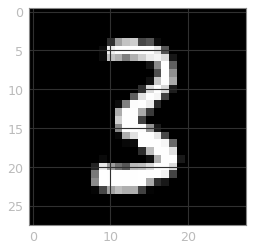

In [121]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [122]:
model,opt = get_model()

In [123]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [124]:
fit()

In [125]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0862, grad_fn=<NllLossBackward>), tensor(0.9844))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [126]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [131]:
small_ds = Dataset(*train_ds[:12])

In [135]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([ 9, 10, 11])]

In [136]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([5, 6, 9]),
 tensor([ 7,  1, 11]),
 tensor([ 8,  0, 10]),
 tensor([2, 3, 4])]

In [137]:
# Because we're not using contiguous indexes anymore we need a collate function to 
# glue the tensors together. This takes a list of tensors, each element made up by
# a pair of x and corresponding y; it then zip them toghether the other way around, i.e.
# as two lists or all the xs and all the ys and then return a pair of tensors
# where each is produced by stacking each element together for both the lists.
def collate(tens_list):
    xs,ys = zip(*tens_list)
    return torch.stack(xs),torch.stack(ys)

# Our new dataloader now can take a sampler as an extra parametes, which will
# be used to generate (yield) the indexes for each minibatch, and they'll be 
# randomized each time an iter is called on it
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [138]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [139]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

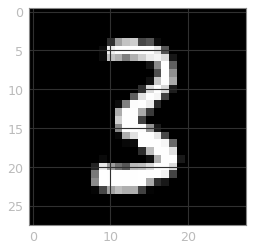

In [140]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(9)

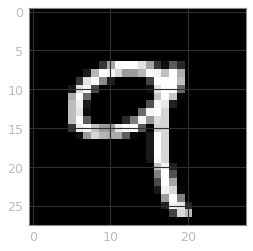

In [141]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

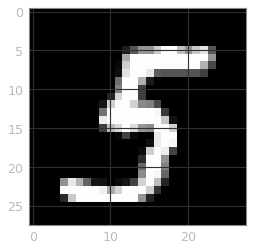

In [142]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [143]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1573, grad_fn=<NllLossBackward>), tensor(0.9688))

### PyTorch DataLoader

In [144]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [145]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)
# sequential sampler is essentially our sampler with shuffle=False
# we can even call it with our callate function!

In [146]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.6641, grad_fn=<NllLossBackward>), tensor(0.8750))

PyTorch's defaults work fine for most things however:

In [147]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [148]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1406, grad_fn=<NllLossBackward>), tensor(0.9688))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset` before collate them together. This is useful if you're grabbing minibatches of big jpeg images and doing expensive transformations on them for example...

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [150]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train() # see above
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval() # see above
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl: # for each batch in the validation set
                pred = model(xb) # predict output
                tot_loss += loss_func(pred, yb) # compute loss and accuracy
                tot_acc  += accuracy (pred,yb) # and cumulat them
                # note that because of no_grad() these do not create graphs
                # and we're not going to call backward() on them anyway
        nv = len(valid_dl) #get the length of the valid set
        print(epoch, tot_loss/nv, tot_acc/nv) # print out something
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

NO, but most of the times this is how it is implemented. Most of the times a DataLoader will actually use a drop_last=True parameter, that divides the dataset into batches of the same size and then drop the remaining data if they're not enough to fill a last batch (recall these are random, so no data is dropped forever but a different set is dropped at every epoch)

`get_dls` returns dataloaders for the training and validation sets:

In [151]:
#export
def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=batch_size*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [152]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1517) tensor(0.9559)
1 tensor(0.1123) tensor(0.9665)
2 tensor(0.1939) tensor(0.9389)
3 tensor(0.1069) tensor(0.9674)
4 tensor(0.1057) tensor(0.9684)


In [153]:
assert acc>0.9

Note as well that these accuracy and loss values are now from the validation set!

## Export

In [154]:
!python3 notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
